# Project 1 - Font Generation using GAN

In [1]:
import tarfile
#Download and unzip the dataset to your local machine
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz -O notMNIST_small.tar.gz
tar = tarfile.open("notMNIST_small.tar.gz")
tar.extractall()
tar.close()

In [1]:
import numpy as np
from scipy.misc import imread,imresize
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})
import numpy as np


import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
from keras import backend as K
# import theano as th
# import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
import seaborn as sns
import _pickle as cPickle
from keras.models import Model
from IPython import display

from keras.utils import np_utils
from tqdm import tqdm

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
IMG_SHAPE = (28,28)

In [3]:
data = []
classes = []
for path in glob('notMNIST_small\\*\\*'):
    try:
        classes.append(path.split('\\')[-2])
        data.append(imresize(imread(path, "PNG"),IMG_SHAPE))
    except Exception as e:
        print("failed:",path)
        print(e)

failed: notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY.png
cannot identify image file 'notMNIST_small\\A\\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY.png'
failed: notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
cannot identify image file 'notMNIST_small\\A\\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png'
failed: notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
cannot identify image file 'notMNIST_small\\F\\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png'


In [4]:
data = np.stack(data)[:,None]
data = data.astype('float32')/ 255.

# #convert classes to 1-hot
# N_CLASSES = len(set(classes))
# LETTERS="ABCDEFGHIJ"
# letter_to_i = {l:i for i,l in enumerate(LETTERS)}

# from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# classes = np.array(list(map(letter_to_i.get, classes)))
# classes = OneHotEncoder(sparse=False,dtype='float32').fit_transform(classes[:,None])

In [5]:
print(data.max())
print(data.min())

1.0
0.0


In [6]:
data.shape

(18724, 1, 28, 28)

In [7]:
# plot n images (limit n under 12)
def plot_n(n, img):
    plt.figure(figsize=(18, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(img[i].reshape(28, 28), cmap="gray", interpolation="none")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [8]:
# randomly display 10 original images
total = data.shape[0]
img = data[np.random.randint(0, total, 10)]

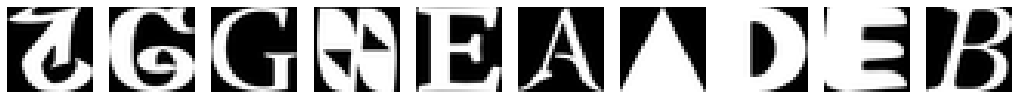

In [15]:
img = data[np.random.randint(0, total, 10)]
plot_n(10, img)

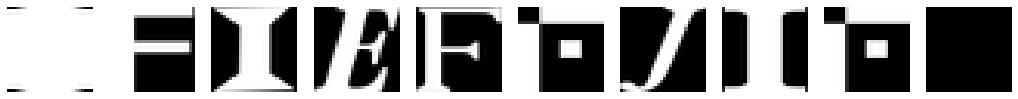

In [18]:
img = data[np.random.randint(0, total, 10)]
plot_n(10, img)

In [9]:
# x_train, x_test = train_test_split(data, test_size = 0.2)
x_train = data

In [10]:
# print(x_train.shape)
# print(x_test.shape)
# print("Train/Test Ratio: ", x_train.shape[0]/x_test.shape[0], "/1", sep='')

In [11]:
dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-5)


In [12]:
# Build Generative model
# input shape set as 128
g_input = Input(shape=[128])
H = Dense(256*14*14, kernel_initializer='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape([256, 14, 14])(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(128, 3, padding='same', kernel_initializer='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(64, 3, padding='same', kernel_initializer='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
# generator.summary()

In [13]:
# Build Discriminative model
d_input = Input(shape=(1, 28, 28))
H = Conv2D(128, (5, 5), padding="same", strides=(2, 2))(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(256, (5, 5), padding="same", strides=(2, 2))(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
# discriminator.summary()

In [14]:
# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=[128])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='binary_crossentropy', optimizer=opt)
# GAN.summary()

In [15]:
def plot_sample_real(n_ex=16,dim=(4,4), figsize=(8,8) ):
    
    idx = np.random.randint(0,x_train.shape[0],n_ex)
    gen_img = x_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(gen_img.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = gen_img[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(8,6))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [17]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(8,8) ):
    noise = np.random.uniform(0,1,size=[n_ex,128])
    gen_img = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(gen_img.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = gen_img[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [18]:
x_train.shape[0]

18724

In [19]:
N = 10000
trainidx = random.sample(range(0,x_train.shape[0]), N)
XT = x_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],128])
gen_img = generator.predict(noise_gen)
X = np.concatenate((XT, gen_img))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, epochs=1, batch_size=32, verbose=2)
y_pred = discriminator.predict(X)

Epoch 1/1
11s - loss: 0.1747


In [20]:
y_pred_idx = np.argmax(y_pred,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_pred_idx
nt = y.shape[0]
nr = (diff==0).sum()
accuracy = nr*100.0/nt
print("Accuracy: %0.02f pct (%d of %d) right"%(accuracy, nr, nt))

# set up loss storage vector
losses = {"d":[], "g":[]}

Accuracy: 99.16 pct (19832 of 20000) right


In [22]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = x_train[np.random.randint(0,x_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,128])
        gen_img = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, gen_img))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,128])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
#             plot_gen()

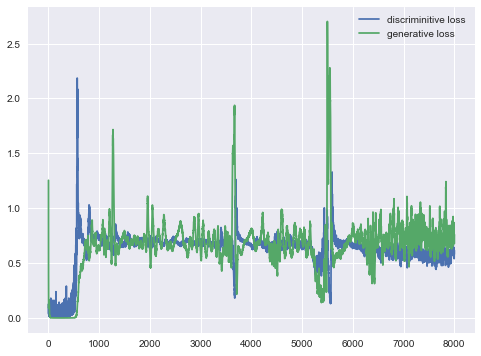

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [15:29<00:00,  6.26it/s]


In [23]:
# train for 8,000 epochs
train_for_n(nb_epoch=8000, plt_frq=100,BATCH_SIZE=32)

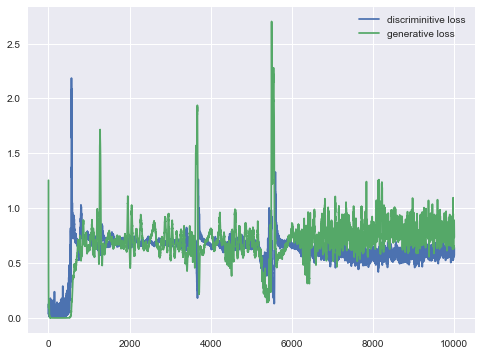

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:52<00:00,  6.27it/s]


In [26]:
# train for another 2,000 epochs
train_for_n(nb_epoch=2000, plt_frq=100,BATCH_SIZE=32)

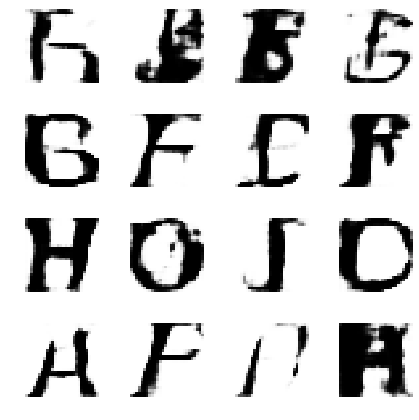

In [32]:
plot_gen(16,(4,4),(6,6))

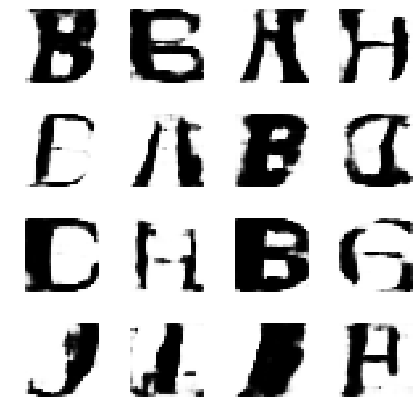

In [30]:
plot_gen(16,(4,4),(6,6))

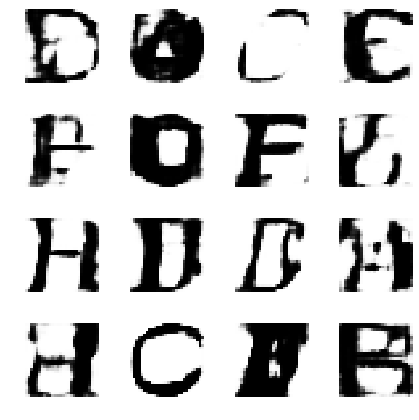

In [53]:
plot_gen(16,(4,4),(6,6))

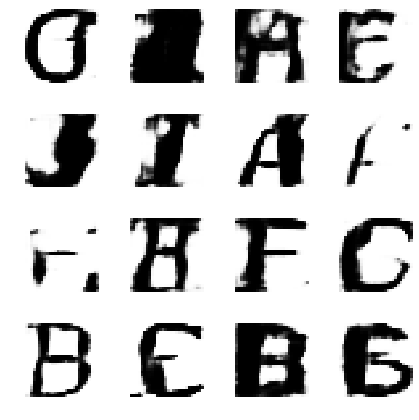

In [69]:
plot_gen(16,(4,4),(6,6))

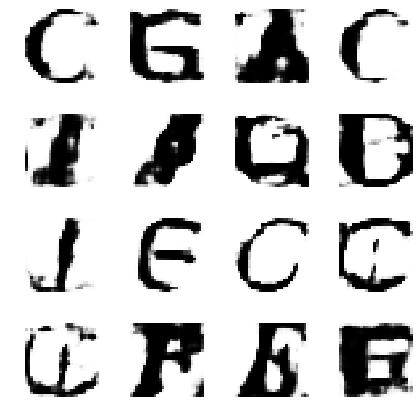

In [62]:
plot_gen(16,(4,4),(6,6))

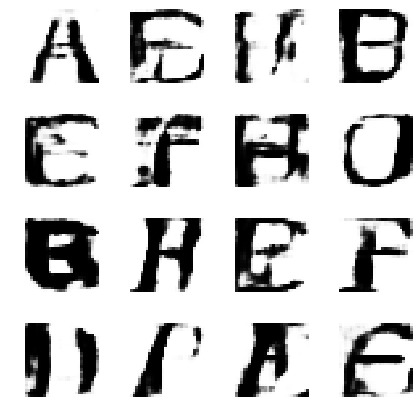

In [68]:
plot_gen(16,(4,4),(6,6))

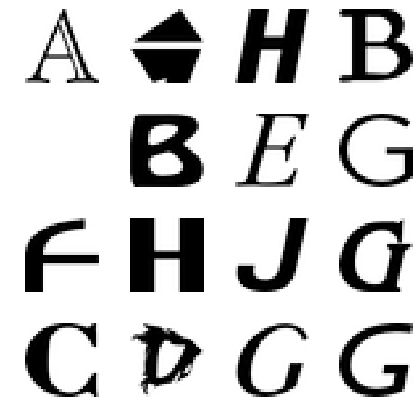

In [46]:
# plot samples from real dataset for comperison
plot_sample_real(16,(4,4),(6,6))

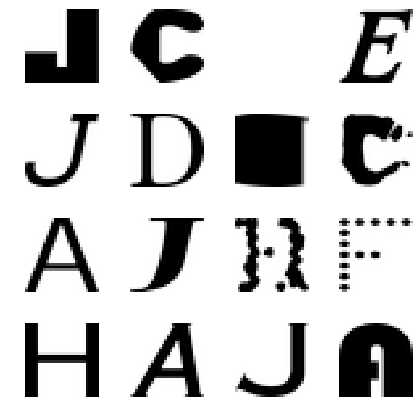

In [52]:
plot_sample_real(16,(4,4),(6,6))

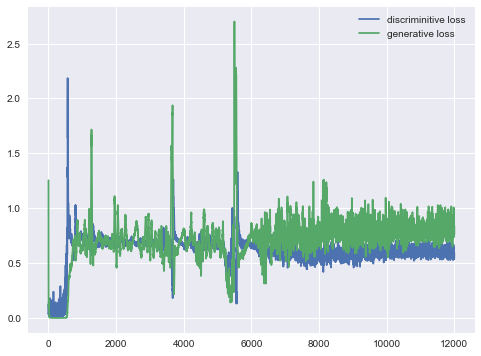

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:51<00:00,  6.07it/s]


In [72]:
# One more time, train for another 2,000 epochs, now we have run for 12,000 epochs in total

train_for_n(nb_epoch=2000, plt_frq=100,BATCH_SIZE=32)

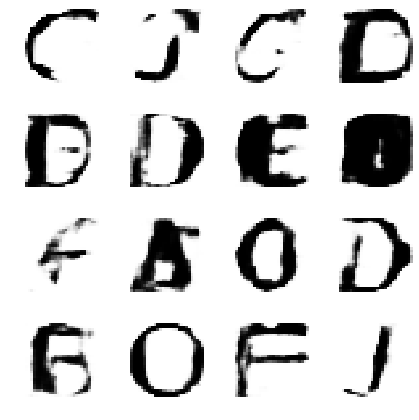

In [82]:
plot_gen(16,(4,4),(6,6))

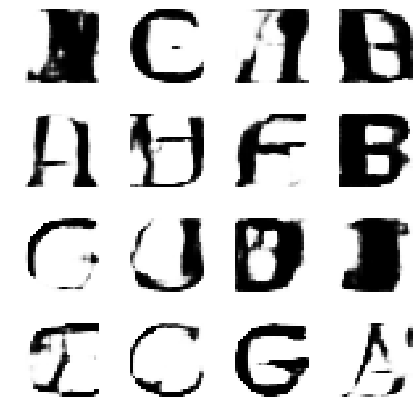

In [84]:
plot_gen(16,(4,4),(6,6))